<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression

In [ ]:
data = pd.read_excel("https://raw.githubusercontent.com/AntoninaRemizova/ML/refs/heads/main/Japan.xlsx")
data.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Япония,20.07.2020,25680,19603.0,988,418,392.0,2,127110047,562726,12114
1,Япония,21.07.2020,26312,20001.0,989,632,398.0,1,127110047,579083,16357
2,Япония,22.07.2020,27107,20482.0,990,795,481.0,1,127110047,587393,8310
3,Япония,23.07.2020,28088,20878.0,992,981,396.0,2,127110047,593088,5695
4,Япония,24.07.2020,28867,21173.0,995,779,295.0,3,127110047,602618,9530


In [ ]:
TARGET_COL = 'Заражений за день'
DATE_COL = 'Дата'
FEATURE_2_COL = 'Тестов за день'
FEATURE_3_COL = 'Смертей за день'
N = 100
TRAIN_SIZE = 80
TEST_SIZE = 20

In [ ]:
data[DATE_COL] = pd.to_datetime(data[DATE_COL], format="%d.%m.%Y")
data['Day'] = (data[DATE_COL] - data[DATE_COL].min()).dt.days
data.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,Day
0,Япония,2020-07-20,25680,19603.0,988,418,392.0,2,127110047,562726,12114,0
1,Япония,2020-07-21,26312,20001.0,989,632,398.0,1,127110047,579083,16357,1
2,Япония,2020-07-22,27107,20482.0,990,795,481.0,1,127110047,587393,8310,2
3,Япония,2020-07-23,28088,20878.0,992,981,396.0,2,127110047,593088,5695,3
4,Япония,2020-07-24,28867,21173.0,995,779,295.0,3,127110047,602618,9530,4


In [ ]:
df_series = data.head(N).reset_index(drop=True)
Y_full = df_series[TARGET_COL]

In [ ]:
X_REG = df_series[['Day', FEATURE_2_COL, FEATURE_3_COL]]
Y_REG = df_series[TARGET_COL]

In [ ]:
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(
    X_REG, Y_REG, test_size=TEST_SIZE, shuffle=False
)

# ARIMA

In [ ]:
y_train_arima = Y_full[:TRAIN_SIZE]
y_test_arima = Y_full[TRAIN_SIZE:]

model_arima = ARIMA(y_train_arima, order=(5, 0, 1))
results_arima = model_arima.fit()
forecast_arima = results_arima.forecast(steps=TEST_SIZE)

# k-NN

In [ ]:
def create_lagged_features(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

n_lags = 3
X_lag, Y_lag = create_lagged_features(Y_full, n_lags)

X_train_lag, X_test_lag = X_lag[:TRAIN_SIZE - n_lags], X_lag[TRAIN_SIZE - n_lags:]
y_train_lag, y_test_lag = Y_lag[:TRAIN_SIZE - n_lags], Y_lag[TRAIN_SIZE - n_lags:]

model_knn = KNeighborsRegressor(n_neighbors=5, weights='uniform')
model_knn.fit(X_train_lag, y_train_lag)
forecast_knn = model_knn.predict(X_test_lag)

# МНК и SVM с одним параметром

In [ ]:
X1_train = X_train_reg[['Day']]
X1_test = X_test_reg[['Day']]

# МНК
poly = PolynomialFeatures(degree=2, include_bias=False)
X1_poly_train = poly.fit_transform(X1_train)
X1_poly_test = poly.transform(X1_test)

model_lr_poly = LinearRegression()
model_lr_poly.fit(X1_poly_train, Y_train_reg)
forecast_lr_poly = model_lr_poly.predict(X1_poly_test)

# SVM
model_svr_1 = SVR(kernel='rbf', C=100, epsilon=100)
model_svr_1.fit(X1_train, Y_train_reg)
forecast_svr_1 = model_svr_1.predict(X1_test)

# МНК и SVM с двумя параметрами

In [ ]:
X2_train = X_train_reg[['Day', FEATURE_2_COL]]
X2_test = X_test_reg[['Day', FEATURE_2_COL]]

# МНК
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
X2_poly_train = poly_2.fit_transform(X2_train)
X2_poly_test = poly_2.transform(X2_test)

model_lr_poly_2 = LinearRegression()
model_lr_poly_2.fit(X2_poly_train, Y_train_reg)
forecast_lr_2 = model_lr_poly_2.predict(X2_poly_test)

# SVM
model_svr_2 = SVR(kernel='rbf', C=100, epsilon=100)
model_svr_2.fit(X2_train, Y_train_reg)
forecast_svr_2 = model_svr_2.predict(X2_test)

# МНК и SVM с тремя параметрами

In [ ]:
X3_train = X_train_reg[['Day', FEATURE_2_COL, FEATURE_3_COL]]
X3_test = X_test_reg[['Day', FEATURE_2_COL, FEATURE_3_COL]]

# МНК
model_lr_3 = LinearRegression()
model_lr_3.fit(X3_train, Y_train_reg)
forecast_lr_3 = model_lr_3.predict(X3_test)

# SVM
model_svr_3 = SVR(kernel='rbf', C=100, epsilon=100)
model_svr_3.fit(X3_train, Y_train_reg)
forecast_svr_3 = model_svr_3.predict(X3_test)

# Сравнение

| Модель                     |    MAE |   RMSE |     R2 |
|:---------------------------|-------:|-------:|-------:|
| k-NN (лаг = 3, соседи = 5) |  75.23 |  98.47 |   0.42 |
| ARIMA(лаг = 5)             |  93.23 | 117.24 |   0.18 |
| SVR                        | 109.62 | 137.04 |  -0.12 |
| SVR (x2)                   | 124.10 | 163.83 |  -0.60 |
| SVR (x3)                   | 130.90 | 170.60 |  -0.73 |
| МНК (x3)                   | 298.23 | 328.40 |  -5.42 |
| МНК (x2)                   | 428.91 | 459.98 | -11.60 |
| МНК                        | 450.67 | 482.43 | -12.86 |


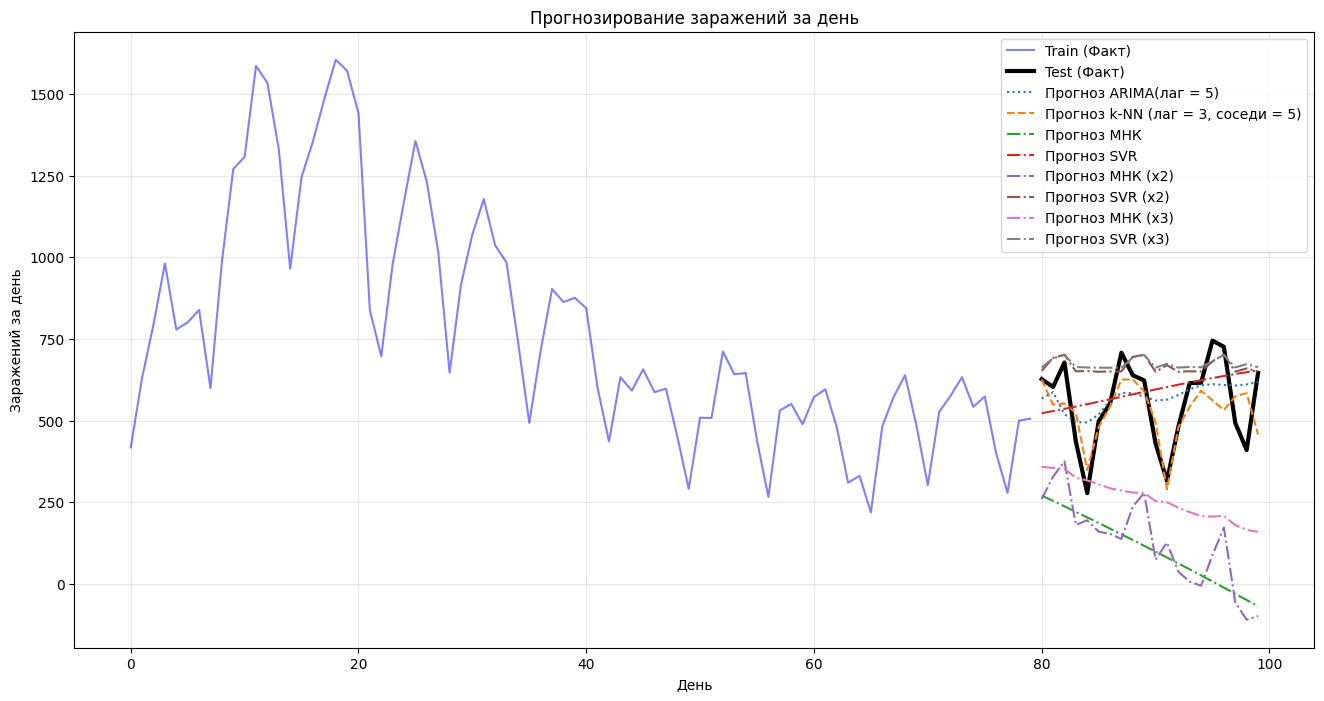

In [ ]:
all_models_forecasts = {
    'ARIMA(лаг = 5)': forecast_arima,
    'k-NN (лаг = 3, соседи = 5)': forecast_knn,
    'МНК': forecast_lr_poly,
    'SVR': forecast_svr_1,
    'МНК (x2)': forecast_lr_2,
    'SVR (x2)': forecast_svr_2,
    'МНК (x3)': forecast_lr_3,
    'SVR (x3)': forecast_svr_3
}

# Метрики
metrics_data = []
actual_values = Y_test_reg.values

for name, pred in all_models_forecasts.items():
    if 'k-NN' in name:
        y_true_temp = y_test_lag
        pred_temp = pred
    else:
        y_true_temp = actual_values
        pred_temp = pred

    mae = mean_absolute_error(y_true_temp, pred_temp)
    rmse = np.sqrt(mean_squared_error(y_true_temp, pred_temp))
    r2 = r2_score(y_true_temp, pred_temp)
    metrics_data.append([name, mae, rmse, r2])

metrics_df = pd.DataFrame(metrics_data, columns=['Модель', 'MAE', 'RMSE', 'R2'])
metrics_df = metrics_df.sort_values(by='MAE')

print(metrics_df.to_markdown(index=False, floatfmt=".2f"))

# Визуализация
plt.figure(figsize=(16, 8))
plt.plot(np.arange(TRAIN_SIZE), Y_train_reg, label='Train (Факт)', color='b', alpha=0.5)
plt.plot(np.arange(TRAIN_SIZE, N), Y_test_reg, label='Test (Факт)', color='k', linewidth=3)
test_index = np.arange(TRAIN_SIZE, N)

for name, pred in all_models_forecasts.items():
    if 'k-NN' in name:
        plt.plot(test_index, pred, linestyle='--', label=f'Прогноз {name}')
    elif 'ARIMA' in name:
        plt.plot(test_index, pred, linestyle=':', label=f'Прогноз {name}')
    else:
        plt.plot(test_index, pred, linestyle='-.', label=f'Прогноз {name}')

plt.title('Прогнозирование заражений за день')
plt.xlabel('День')
plt.ylabel(TARGET_COL)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# МНК и SVM с предыдущим значением

In [ ]:
df_lagged = df_series.copy()
df_lagged['Lag_1'] = df_lagged[TARGET_COL].shift(1)
df_lagged = df_lagged.dropna().reset_index(drop=True)

X4_cols = ['Day', FEATURE_2_COL, FEATURE_3_COL, 'Lag_1']
X4 = df_lagged[X4_cols]
Y_lagged = df_lagged[TARGET_COL]

N_lagged = len(df_lagged)
TRAIN_SIZE_LAGGED = N_lagged - TEST_SIZE

X4_train, X4_test, Y_train_lagged, Y_test_lagged = train_test_split(
    X4, Y_lagged, test_size=TEST_SIZE, shuffle=False
)

# МНК
model_lr_lag = LinearRegression()
model_lr_lag.fit(X4_train, Y_train_lagged)
forecast_lr_lag = model_lr_lag.predict(X4_test)

# SVR
model_svr_lag = SVR(kernel='rbf', C=100, epsilon=100)
model_svr_lag.fit(X4_train, Y_train_lagged)
forecast_svr_lag = model_svr_lag.predict(X4_test)

In [ ]:
def refit_and_evaluate(model_name, model_class, train_size, features, params={}):
    df_subset = df_lagged.tail(train_size + TEST_SIZE).reset_index(drop=True)
    X_sub = df_subset[features]
    Y_sub = df_subset[TARGET_COL]

    X_train_sub, X_test_sub, Y_train_sub, Y_test_sub = train_test_split(
        X_sub, Y_sub, test_size=TEST_SIZE, shuffle=False
    )

    model = model_class(**params)
    model.fit(X_train_sub, Y_train_sub)
    forecast = model.predict(X_test_sub)

    mae = mean_absolute_error(Y_test_sub, forecast)
    rmse = np.sqrt(mean_squared_error(Y_test_sub, forecast))
    r2 = r2_score(Y_test_sub, forecast)

    return f"{model_name} (лаг = 1, train = {train_size})", mae, rmse, r2, forecast

In [ ]:
# train = 20
res_lr_20 = refit_and_evaluate('МНК', LinearRegression, 20, X4_cols)
res_svr_20 = refit_and_evaluate('SVR', SVR, 20, X4_cols, {'kernel':'rbf', 'C':100, 'epsilon':100})
forecast_lr_20 = res_lr_20[4]
forecast_svr_20 = res_svr_20[4]

# train = 40
res_lr_40 = refit_and_evaluate('МНК', LinearRegression, 40, X4_cols)
res_svr_40 = refit_and_evaluate('SVR', SVR, 40, X4_cols, {'kernel':'rbf', 'C':100, 'epsilon':100})
forecast_lr_40 = res_lr_40[4]
forecast_svr_40 = res_svr_40[4]

# Lasso и PLS

In [ ]:
model_lasso = Lasso(alpha=0.1, max_iter=10000, random_state=42)
model_lasso.fit(X3_train, Y_train_reg)
forecast_lasso = model_lasso.predict(X3_test)

model_pls = PLSRegression(n_components=2)
model_pls.fit(X3_train, Y_train_reg)
forecast_pls = model_pls.predict(X3_test).flatten()

# Метрики

In [ ]:
final_metrics_data = metrics_data.copy()

# Метрики
final_metrics_data.append(['МНК (лаг = 1, train = 80)', mean_absolute_error(Y_test_lagged, forecast_lr_lag), np.sqrt(mean_squared_error(Y_test_lagged, forecast_lr_lag)), r2_score(Y_test_lagged, forecast_lr_lag)])
final_metrics_data.append(['SVR (лаг = 1, train = 80)', mean_absolute_error(Y_test_lagged, forecast_svr_lag), np.sqrt(mean_squared_error(Y_test_lagged, forecast_svr_lag)), r2_score(Y_test_lagged, forecast_svr_lag)])
final_metrics_data.append(['Lasso', mean_absolute_error(Y_test_reg, forecast_lasso), np.sqrt(mean_squared_error(Y_test_reg, forecast_lasso)), r2_score(Y_test_reg, forecast_lasso)])
final_metrics_data.append(['PLS', mean_absolute_error(Y_test_reg, forecast_pls), np.sqrt(mean_squared_error(Y_test_reg, forecast_pls)), r2_score(Y_test_reg, forecast_pls)])
final_metrics_data.append([res_lr_20[0], res_lr_20[1], res_lr_20[2], res_lr_20[3]])
final_metrics_data.append([res_svr_20[0], res_svr_20[1], res_svr_20[2], res_svr_20[3]])
final_metrics_data.append([res_lr_40[0], res_lr_40[1], res_lr_40[2], res_lr_40[3]])
final_metrics_data.append([res_svr_40[0], res_svr_40[1], res_svr_40[2], res_svr_40[3]])

final_metrics_df = pd.DataFrame(final_metrics_data, columns=['Модель', 'MAE', 'RMSE', 'R2'])
final_metrics_df = final_metrics_df.sort_values(by='MAE').drop_duplicates(subset='Модель', keep='first')

print(final_metrics_df.to_markdown(index=False, floatfmt=".2f"))



| Модель                     |    MAE |   RMSE |     R2 |
|:---------------------------|-------:|-------:|-------:|
| k-NN (лаг = 3, соседи = 5) |  75.23 |  98.47 |   0.42 |
| МНК (лаг = 1, train = 40)  | 101.72 | 116.38 |   0.19 |
| SVR (лаг = 1, train = 40)  | 108.62 | 128.94 |   0.01 |
| SVR                        | 109.62 | 137.04 |  -0.12 |
| МНК (лаг = 1, train = 20)  | 111.64 | 129.63 |  -0.00 |
| ARIMA(лаг = 5)             | 112.23 | 133.22 |  -0.06 |
| SVR (x2)                   | 124.10 | 163.83 |  -0.60 |
| SVR (x3)                   | 130.90 | 170.60 |  -0.73 |
| SVR (лаг = 1, train = 20)  | 132.89 | 154.26 |  -0.42 |
| SVR (лаг = 1, train = 80)  | 135.89 | 175.95 |  -0.84 |
| МНК (лаг = 1, train = 80)  | 154.46 | 180.59 |  -0.94 |
| PLS                        | 296.37 | 327.34 |  -5.38 |
| МНК (x3)                   | 298.23 | 328.40 |  -5.42 |
| Lasso                      | 298.24 | 328.41 |  -5.42 |
| МНК (x2)                   | 428.91 | 459.98 | -11.60 |
| МНК         

# Визуализация

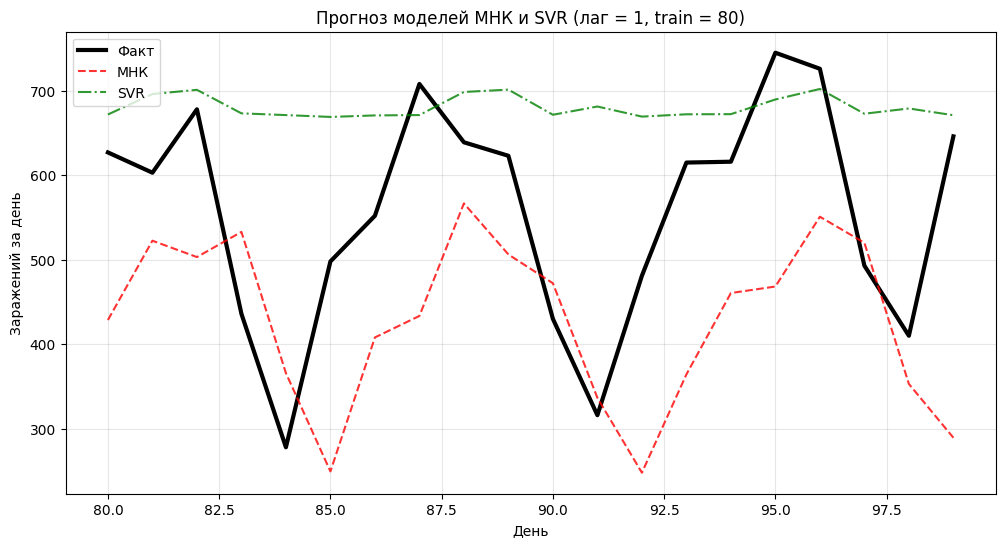

In [ ]:
test_index_plot = np.arange(N - TEST_SIZE, N)
actual_test_values = Y_test_reg.values

plt.figure(figsize=(12, 6))
plt.plot(test_index_plot, actual_test_values, label='Факт', color='k', linewidth=3)
plt.plot(test_index_plot, forecast_lr_lag, linestyle='--', label='МНК', color='r', alpha=0.8)
plt.plot(test_index_plot, forecast_svr_lag, linestyle='-.', label='SVR', color='g', alpha=0.8)

plt.title('Прогноз моделей МНК и SVR (лаг = 1, train = 80)')
plt.xlabel('День')
plt.ylabel(TARGET_COL)
plt.legend(loc='upper left', ncol=1)
plt.grid(True, alpha=0.3)
plt.show()


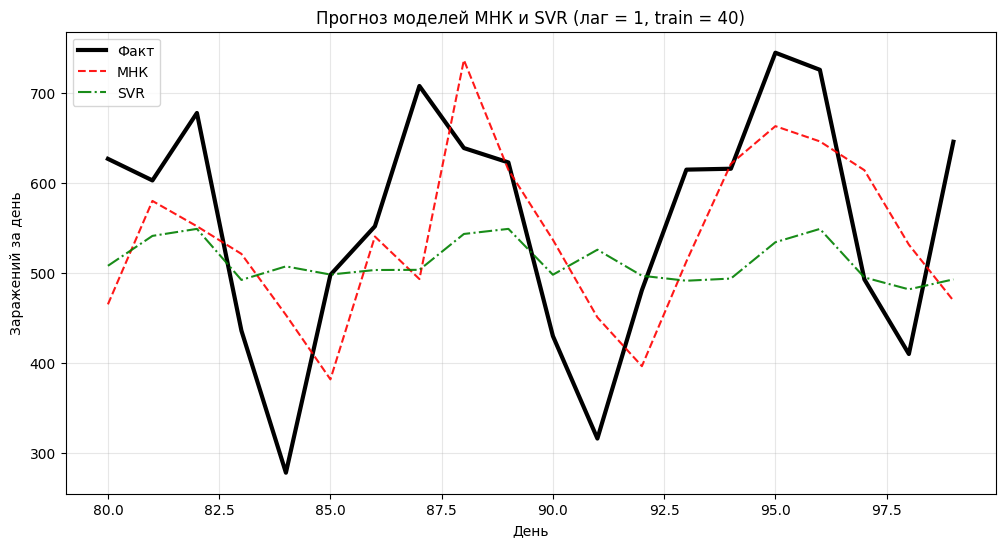

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_index_plot, actual_test_values, label='Факт', color='k', linewidth=3)
plt.plot(test_index_plot, forecast_lr_40, linestyle='--', label='МНК', color='r', alpha=0.9)
plt.plot(test_index_plot, forecast_svr_40, linestyle='-.', label='SVR', color='g', alpha=0.9)

plt.title('Прогноз моделей МНК и SVR (лаг = 1, train = 40)')
plt.xlabel('День')
plt.ylabel(TARGET_COL)
plt.legend(loc='upper left', ncol=1)
plt.grid(True, alpha=0.3)
plt.show()

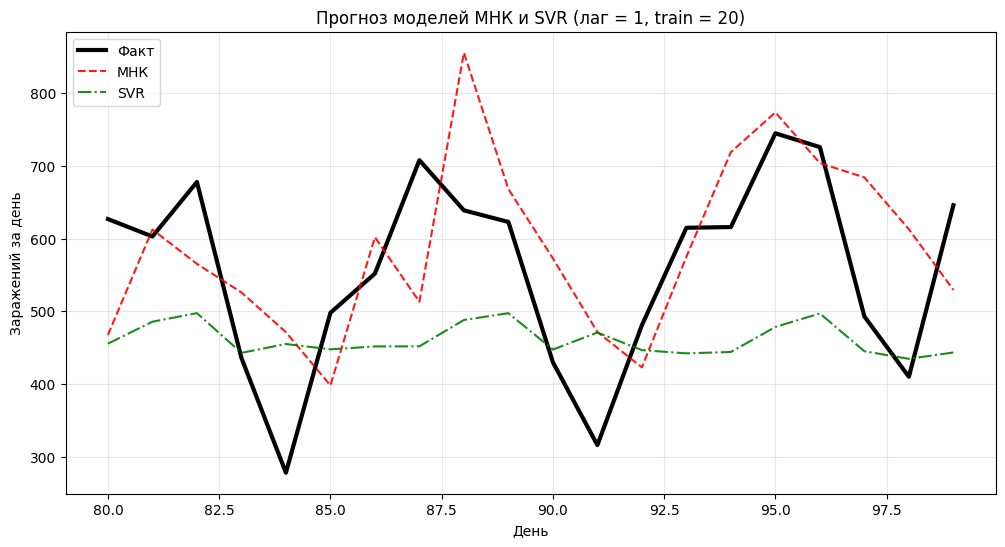

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_index_plot, actual_test_values, label='Факт', color='k', linewidth=3)
plt.plot(test_index_plot, forecast_lr_20, linestyle='--', label='МНК', color='r', alpha=0.9)
plt.plot(test_index_plot, forecast_svr_20, linestyle='-.', label='SVR', color='g', alpha=0.9)

plt.title('Прогноз моделей МНК и SVR (лаг = 1, train = 20)')
plt.xlabel('День')
plt.ylabel(TARGET_COL)
plt.legend(loc='upper left', ncol=1)
plt.grid(True, alpha=0.3)
plt.show()

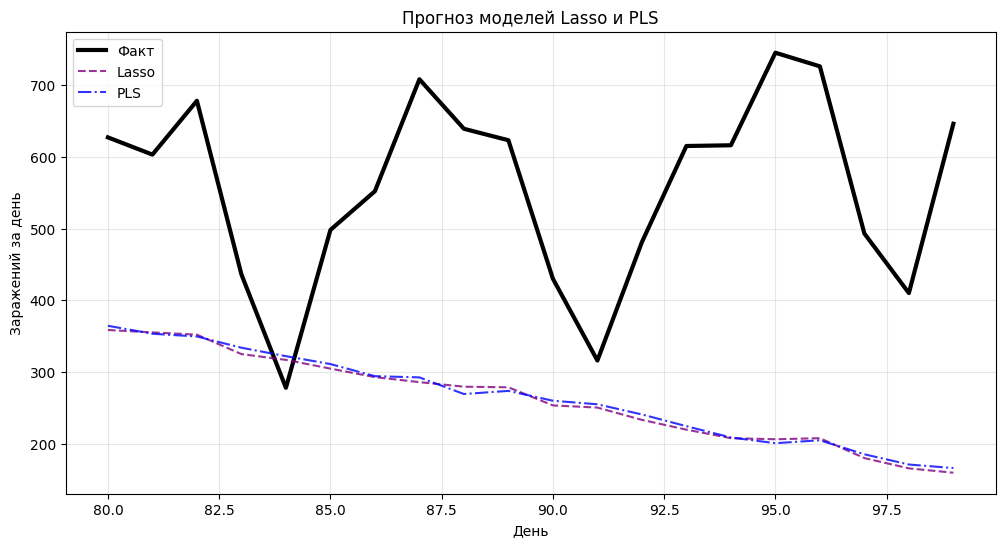

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_index_plot, actual_test_values, label='Факт', color='k', linewidth=3)
plt.plot(test_index_plot, forecast_lasso, linestyle='--', label='Lasso', color='purple', alpha=0.8)
plt.plot(test_index_plot, forecast_pls, linestyle='-.', label='PLS', color='blue', alpha=0.8)

plt.title('Прогноз моделей Lasso и PLS')
plt.xlabel('День')
plt.ylabel(TARGET_COL)
plt.legend(loc='upper left', ncol=1)
plt.grid(True, alpha=0.3)
plt.show()